# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import warnings
warnings.filterwarnings("ignore")
print("ok")

ok


# Load train Data and Feature Process

In [2]:
# 1. load data
end_df = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/test.csv")  # 替换为你的数据路径
end_df['text'] = end_df['QuestionText'] + " " + end_df['MC_Answer']+" "+ end_df['StudentExplanation']

df = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train.csv") 
df['text'] = df['QuestionText'] + " " + df['MC_Answer']+" "+ df['StudentExplanation']


df['Misconception'] = df['Misconception'].fillna('NA').astype(str) #fillna NA
df['target_cat'] = df.apply(
    lambda x: x['Category'] + ":" + x['Misconception'], axis=1
) # Category:Misconception 


# 2. feature (the code copy from @abdmental01 MAP - XGB notebook to process feature)
re_frac_slash = re.compile(r'(\d+)\s*/\s*(\d+)')
re_frac_latex = re.compile(r'\\frac\{([^\}]+)\}\{([^\}]+)\}')
re_newlines = re.compile(r'\n+')
re_spaces = re.compile(r'\s+')
re_punct = re.compile(r'[^a-zA-Z0-9\s_]')

def txt_clean(text):
    text = re_frac_slash.sub(r'FRAC_\1_\2', text)
    text = re_frac_latex.sub(r'FRAC_\1_\2', text)
    text = re_newlines.sub(' ', text)
    text = re_spaces.sub(' ', text)
    text = re_punct.sub('', text)
    return text.strip().lower()

def extract_math_features(text):
    text = text.lower()

    features = {}
    features['frac_count'] = len(re.findall(r'FRAC_\d+_\d+|\\frac', text))
    features['number_count'] = len(re.findall(r'\b\d+\b', text))
    features['operator_count'] = len(re.findall(r'[\+\-\*\/\=]', text))
    features['multiply_sign_count'] = len(re.findall(r'[\*×·]|times', text))
    features['power_count'] = len(re.findall(r'\^|\*\*|\b[sS]quared\b|\b[cC]ubed\b', text))

    return features

def fast_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def create_features(df, is_train=True):
    df['mc_answer_len'] = df['MC_Answer'].astype(str).str.len()
    df['explanation_len'] = df['StudentExplanation'].astype(str).str.len()
    df['question_len'] = df['QuestionText'].astype(str).str.len()

    df['explanation_to_question_ratio'] = df['explanation_len'] / (df['question_len'] + 1)

    for col in ['QuestionText', 'MC_Answer']:
        math_features = df[col].apply(extract_math_features).apply(pd.Series)
        prefix = 'mc_' if col == 'MC_Answer' else ''
        math_features.columns = [f'{prefix}{c}' for c in math_features.columns]
        df = pd.concat([df, math_features], axis=1)

    return df


print(f"Train shape: {df.shape}")


df = create_features(df, is_train=True)
end_df = create_features(end_df, is_train=False)

df['cleaned_text'] = df['text'].apply(txt_clean).apply(fast_lemmatize)
end_df['cleaned_text'] = end_df['text'].apply(txt_clean).apply(fast_lemmatize)

# encoded target_cat
le = LabelEncoder()
df['target_encoded'] = le.fit_transform(df['target_cat'])
target_classes = le.classes_
n_classes = len(target_classes)
print(f"Number of target classes: {n_classes}")




# 3. Extract TF-IDF features from text / 提取 TF-IDF 特征
tfidf = TfidfVectorizer(
    max_features=10000,  # Limit features  / 限制特征数
    ngram_range=(1, 2),  # use unigram + bigram 
    stop_words='english',  # Remove common / 去除英文停用词
    min_df=5  # Ignore low word / 排除低频词
)


total_embedding = pd.concat([df['cleaned_text'], end_df['cleaned_text']])
tfidf.fit(total_embedding)

train_embed = tfidf.transform(df['cleaned_text'])
test_embed = tfidf.transform(end_df['cleaned_text'])
print("ok")

Train shape: (36696, 9)
Number of target classes: 65
ok


In [3]:
# 4. List of numerical feature columns
num_cols = ['mc_answer_len', 'explanation_len', 'question_len','explanation_to_question_ratio', 'frac_count',
            'number_count','operator_count', 'mc_frac_count', 'mc_number_count','mc_operator_count']

num_fe = [f for f in num_cols if f in df.columns]

train_num = df[num_fe].fillna(0).values
test_num = end_df[num_fe].fillna(0).values

# Horizontally stack sparse matrices:
train_ = sparse.hstack([train_embed, sparse.csr_matrix(train_num)])
test_ = sparse.hstack([test_embed, sparse.csr_matrix(test_num)])

print(f"Train Final Shape: {train_.shape}")
print(f"Test Final Shape: {test_.shape}")


X_features = hstack([train_embed, csr_matrix(train_num)])  # Combine sparse matrices
 
y = df['target_encoded'].values  # Ensure y is a NumPy array
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42
)
 
print("ok")

Train Final Shape: (36696, 6857)
Test Final Shape: (3, 6857)
ok


# CV xgboost to predict Target

In [4]:
oof_preds = np.zeros((train_.shape[0], n_classes))
test_preds = np.zeros((test_.shape[0], n_classes))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'multi:softprob',
    'num_class': n_classes, # Crucial to tell XGBoost the total number of classes
    'eval_metric': 'mlogloss',
    'max_depth': 12, # Adjusted from example to fit current optimal range
    'learning_rate': 0.02, # Adjusted
    'subsample': 0.68, # Adjusted slightly
    'colsample_bytree': 0.68, # Adjusted slightly
    'tree_method': 'gpu_hist',
    'gpu_id': 0, # Assuming GPU is available and ID is 0
    'random_state': 42,
    'n_jobs': -1 # Use all available cores
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_, y)):
    print(f"--- Fold {fold+1}/{skf.n_splits} ---")
    
    # Create DMatrix objects for the current fold
    dtrain = xgb.DMatrix(train_[trn_idx], label=y[trn_idx])
    dvalid = xgb.DMatrix(train_[val_idx], label=y[val_idx])

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1500, # Increased max rounds, rely on early stopping
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=150, # Increased early stopping rounds
        verbose_eval=100 # Print progress every 100 rounds
    )
    
    # Predict OOF probabilities
    oof_preds[val_idx] = model.predict(dvalid, iteration_range=(0, model.best_iteration))
    
    # Accumulate test predictions
    test_preds += model.predict(xgb.DMatrix(test_), iteration_range=(0, model.best_iteration)) / skf.n_splits


# --- Evaluation ---
oof_logloss = log_loss(y, oof_preds)
print(f"\nOOF Log Loss: {oof_logloss:.4f}")

# Convert OOF probabilities to predicted categories
oof_pred_category = np.argmax(oof_preds, axis=1)
 
# 打印分类报告
print("\n=== OOF Classification Report ===")
print(classification_report(
    y, 
    oof_pred_category,
    target_names=[str(c) for c in np.unique(y)],
    digits=4
))



--- Fold 1/5 ---
[0]	valid-mlogloss:3.83881
[100]	valid-mlogloss:0.96915
[200]	valid-mlogloss:0.68277
[300]	valid-mlogloss:0.60677
[400]	valid-mlogloss:0.58071
[500]	valid-mlogloss:0.57200
[600]	valid-mlogloss:0.56941
[700]	valid-mlogloss:0.57003
[776]	valid-mlogloss:0.57125
--- Fold 2/5 ---
[0]	valid-mlogloss:3.84114
[100]	valid-mlogloss:0.95892
[200]	valid-mlogloss:0.67456
[300]	valid-mlogloss:0.59934
[400]	valid-mlogloss:0.57467
[500]	valid-mlogloss:0.56633
[600]	valid-mlogloss:0.56486
[700]	valid-mlogloss:0.56595
[731]	valid-mlogloss:0.56685
--- Fold 3/5 ---
[0]	valid-mlogloss:3.84280
[100]	valid-mlogloss:0.96048
[200]	valid-mlogloss:0.67391
[300]	valid-mlogloss:0.59680
[400]	valid-mlogloss:0.57125
[500]	valid-mlogloss:0.56212
[600]	valid-mlogloss:0.55988
[700]	valid-mlogloss:0.56051
[800]	valid-mlogloss:0.56248
[809]	valid-mlogloss:0.56265
--- Fold 4/5 ---
[0]	valid-mlogloss:3.84095
[100]	valid-mlogloss:0.96305
[200]	valid-mlogloss:0.67504
[300]	valid-mlogloss:0.59504
[400]	valid-

# Visual Confusion Matrix

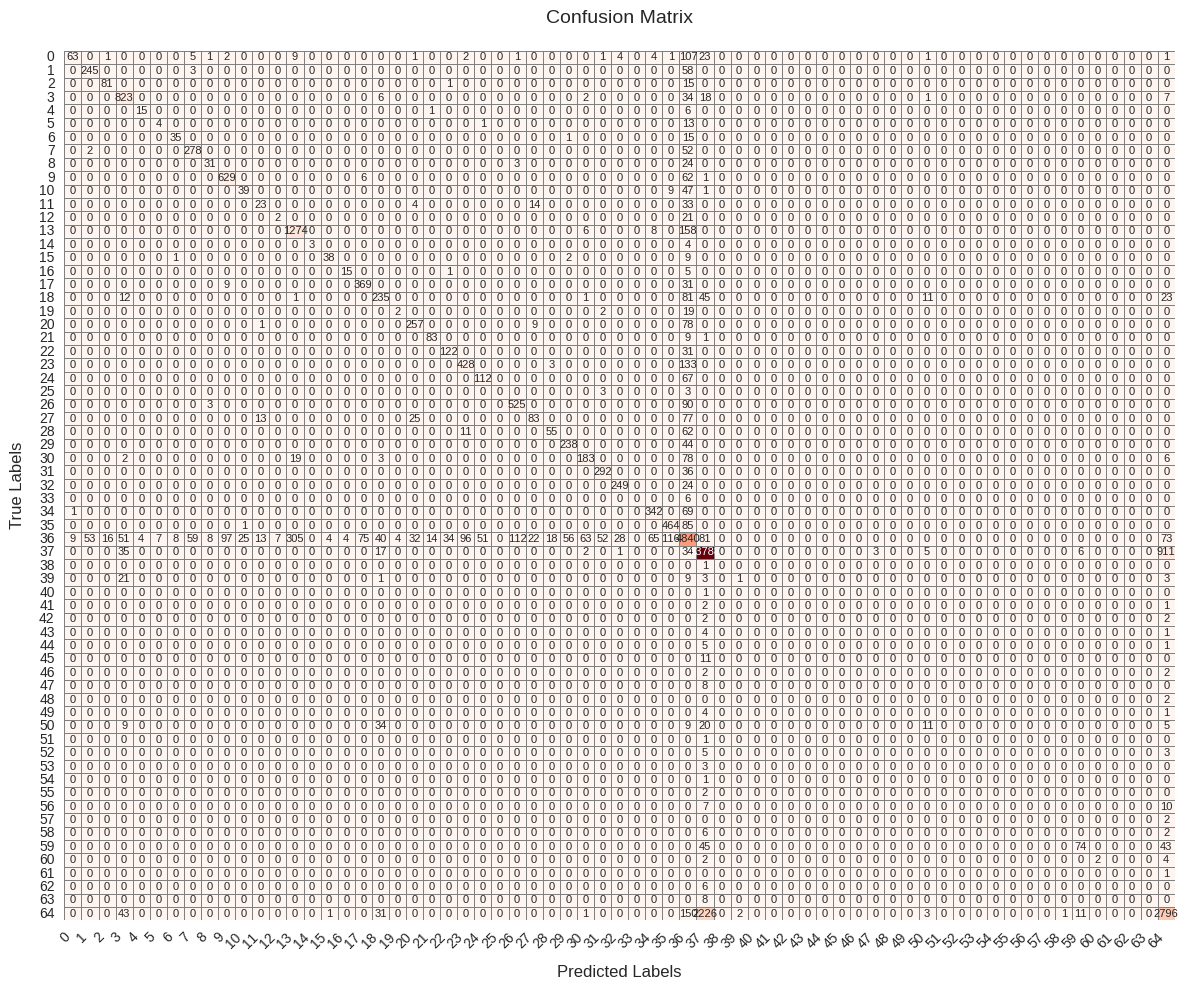

In [5]:
# 计算混淆矩阵
# Calculate evaluation metrics
accuracy = accuracy_score(y, oof_pred_category)
cm = confusion_matrix(y, oof_pred_category)

# Visualization setup with red color scheme and appropriate size
plt.figure(figsize=(12, 10))  
plt.style.use('seaborn')

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Reds',  
    annot_kws={"size": 8},  # font size
    xticklabels=np.unique(y),
    yticklabels=np.unique(y),
    cbar=False,
    linewidths=0.5, #  Add thin borders between cells / 单元格边框
    linecolor='gray'
)

# Improved label display / 优化标签显示
plt.xticks(fontsize=10, rotation=45, ha='right')  
plt.yticks(fontsize=10)

plt.xlabel('Predicted Labels', fontsize=12, labelpad=10)
plt.ylabel('True Labels', fontsize=12, labelpad=10)
plt.title('Confusion Matrix', fontsize=14, pad=20)

# 自动调整布局并添加边距
plt.tight_layout()
plt.show()

# MAP@3 evaluate model

In [6]:
# the code copy from @rajathrpai notebook [CV 0.9188] XGBoost KFold
def calculate_map3_score(true_labels, predicted_prob_arrays, label_encoder):
    """
    Calculates the MAP@3 score.
    true_labels: Series/array of true encoded labels.
    predicted_prob_arrays: Numpy array of predicted probabilities for each class.
    label_encoder: Fitted LabelEncoder object to decode predicted labels.
    """
    score = 0.
    num_samples = len(true_labels)
    
    # Get top 3 predicted class indices for each sample
    top3_indices = predicted_prob_arrays.argsort(axis=1)[:, -3:][:, ::-1]
    
    # Decode true labels to original category:misconception format
    # Ensure true_labels is an array for inverse_transform
    true_decoded_labels = label_encoder.inverse_transform(np.asarray(true_labels))
    
    # Decode predicted labels for MAP@3 calculation
    predicted_decoded_labels_list = []
    for indices_row in top3_indices:
        predicted_decoded_labels_list.append(label_encoder.inverse_transform(indices_row).tolist())

    for t, p_list in zip(true_decoded_labels, predicted_decoded_labels_list):
        if t == p_list[0]: score += 1.
        elif len(p_list) > 1 and t == p_list[1]: score += 1/2
        elif len(p_list) > 2 and t == p_list[2]: score += 1/3
    return score / num_samples


oof_map3_score = calculate_map3_score(y, oof_preds, le)
print(f"OOF MAP@3 Score: {oof_map3_score:.4f}")

OOF MAP@3 Score: 0.8834


# save Submission file

In [7]:
# --- Submission ---
# Get top 3 predictions from averaged test predictions
top3_indices = test_preds.argsort(axis=1)[:, -3:][:, ::-1] # Sort descending and take top 3

test_predictions_labels = []
for indices in top3_indices:
    pred_labels = [target_classes[i] for i in indices]
    test_predictions_labels.append(' '.join(pred_labels))

sample_submission = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/sample_submission.csv")  # 替换为你的数据路径
sample_submission['Category:Misconception'] = test_predictions_labels
submission_filename = "submission.csv" #submission_xgboost_dmatrix_full_features.csv
sample_submission.to_csv(submission_filename, index=False)
print(f"\nSubmission file created: {submission_filename}")
print("XGBoost model training complete with improved features and DMatrix handling.")
sample_submission.head()


Submission file created: submission.csv
XGBoost model training complete with improved features and DMatrix handling.


,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA False_Neither:NA
